<a href="https://colab.research.google.com/github/shraddhapandey100/Forensic_Metadata_Analysis/blob/master/MetadataAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
!pip install pyexiftool


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.2/51.2 kB 3.4 MB/s eta 0:00:00


In [5]:
!apt-get install -y exiftool


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
Note, selecting 'libimage-exiftool-perl' instead of 'exiftool'
The following additional packages will be installed:
  libarchive-zip-perl libmime-charset-perl libsombok3 libunicode-linebreak-perl
Suggested packages:
  libposix-strptime-perl libencode-hanextra-perl libpod2-base-perl
The following NEW packages will be installed:
  libarchive-zip-perl libimage-exiftool-perl libmime-charset-perl libsombok3
  libunicode-linebreak-perl
0 upgraded, 5 newly installed, 0 to remove and 49 not upgraded.
Need to get 3,964 kB of archives.
After this operation, 23.5 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 libarchive-zip-perl all 1.68-1 [90.2 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libimage-exiftool-perl all 12.40+dfsg-1 [3,717 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libmime-charset-perl all 1.012.2-1

**2. Media Analysis**
Purpose: Extract metadata from WhatsApp media files.
Implementation: Use the exiftool via subprocess.

In [6]:
import subprocess

def extract_metadata(file_path):
    try:
        # Run exiftool command
        result = subprocess.run(["exiftool", file_path], stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True)

        # Check if there were errors
        if result.stderr:
            print(f"Error: {result.stderr}")
        else:
            print(result.stdout)
    except Exception as e:
        print(f"An error occurred: {e}")

# Example usage
# Upload a file to Colab before running this
extract_metadata("/example.png")  # Provide the correct file path






ExifTool Version Number         : 12.40
File Name                       : example.png
Directory                       : /
File Size                       : 1235 KiB
File Modification Date/Time     : 2024:12:12 08:30:35+00:00
File Access Date/Time           : 2024:12:12 08:30:33+00:00
File Inode Change Date/Time     : 2024:12:12 08:31:01+00:00
File Permissions                : -rw-r--r--
File Type                       : PNG
File Type Extension             : png
MIME Type                       : image/png
Image Width                     : 968
Image Height                    : 543
Bit Depth                       : 8
Color Type                      : RGB with Alpha
Compression                     : Deflate/Inflate
Filter                          : Adaptive
Interlace                       : Noninterlaced
SRGB Rendering                  : Perceptual
Gamma                           : 2.2
Pixels Per Unit X               : 4724
Pixels Per Unit Y               : 4724
Pixel Units                

**5. Data Visualization**
Matplotlib, Pandas
Purpose: Visualize metadata patterns.

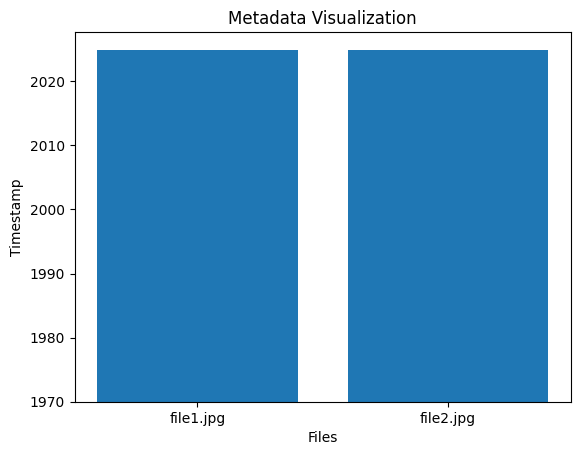

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Create dummy metadata
data = {'Filename': ['file1.jpg', 'file2.jpg'], 'Timestamp': ['2024-12-01', '2024-12-02']}
df = pd.DataFrame(data)

# Visualize timestamps
plt.bar(df['Filename'], pd.to_datetime(df['Timestamp']))
plt.title("Metadata Visualization")
plt.xlabel("Files")
plt.ylabel("Timestamp")
plt.show()


**6. Report Generation**
JSON (Python json module)
Purpose: Structure forensic data.

In [ ]:
import json

# Forensic report data
report_data = {
    "File": "example.jpg",
    "Metadata": {
        "Timestamp": "2024-12-01T12:30:00",
        "Geolocation": "Lat: 37.7749, Long: -122.4194"
    }
}

# Save report as JSON
with open("forensic_report.json", "w") as file:
    json.dump(report_data, file, indent=4)


**7. File Signature Matching**
Custom Python Scripts
Purpose: Match file signatures and recover files.

In [ ]:
def match_file_signature(file_path, signature):
    with open(file_path, "rb") as file:
        content = file.read(len(signature))
        return content == signature

# Example usage
signature = b'\xff\xd8\xff\xe0'  # JPEG signature
print(match_file_signature("/content/example.png", signature))


False


**8. File Extraction**
PyExifTool (Python wrapper)
Purpose: Metadata extraction from various file types.